## HPD Function
<div class="alert alert-info">
Goal: To define a function that calculates the Half POwer Diameter for the FOXSI3-SLF Data (Corrected by darks) as a function of the Azimuthal angle. It uses the three 2D-Gaussians fit to estimate such that values. 
</div>

### Import Packages (Depurar)

In [1]:
from astropy import wcs
from astropy.io import fits as pyfits
from astropy.visualization import ImageNormalize,MinMaxInterval, LogStretch
from ndcube import NDCube
from astropy.modeling import models, fitting
from mpl_toolkits import mplot3d
from scipy.optimize import brentq
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

### Workspace

#### Fit of the Three 2D-Gaussians:

In [2]:
''' Plate scale '''
distance = 2. * u.m ## FOXSI focal distance
CCD_PIXEL_PITCH = 13.5 * u.micron ## Andor CCD Pitch in microns
binning = 2. ## binning used for collecting data.
plate_scale = np.arctan(binning * CCD_PIXEL_PITCH / distance).to(u.arcsec) ## in arcsec

''' Path to the folder where to find your data and darks: '''
folder = '/Users/Kamilobu/Desktop/Developer/foxsi3_optics_cal/data/'

''' File names: '''
filename = 'kFOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_0mmZ.fits'  ## name of your data fits file.
darkfilename = 'Dark1_FOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_+15mmZ.fits'  ## name of your darks fits file.
## These are fits files containing six frames each of 1024x1024 pixels taken at the SLF
## using the Andor camera and the Mo X-ray source. Voltages,Currents and Integration Times are 
## indicated over the names of the files.

## Read fits files using astropy.io.fits
fits = pyfits.open(folder+filename)
darkfits = pyfits.open(folder+darkfilename)

## Create data array corrected by darks:
data = np.average(fits[0].data, axis=0) - np.average(darkfits[0].data, axis=0)

''' Create the WCS information '''
wcs_dict = {
    'CTYPE1':'HPLT-TAN', ## To use sunpy this needs to be in helioporject coord.
    'CTYPE2':'HPLN-TAN', ## Although strange, it does not affect any of the analysis.
    'CUNIT1':'arcsec',
    'CUNIT2':'arcsec',
    'CDELT1': plate_scale.value, ## Plate scale in arcsec
    'CDELT2': plate_scale.value, ## Plate scale in arcsec
    'CRPIX1':0,
    'CRPIX2':0,
    'CRVAL1': 0,
    'CRVAL2': 0,
    'NAXIS1': data.shape[0],
    'NAXIS2': data.shape[1]
}
input_wcs = wcs.WCS(wcs_dict)

''' Create NDCube '''
datacube = NDCube(data, input_wcs)
max_pixel = np.unravel_index(np.argmax(datacube.data), datacube.data.shape)
fov = [20, 20] ## [px,px]

''' Definition of Two 2D-Gaussians function '''
@models.custom_model
def ThreeGaussians(x, y,
                 x_mean=0, y_mean=0, theta=0,
                 amp1=0, x1_stddev=0, y1_stddev=0, ## Gauss1 param
                 amp2=0, x2_stddev=0, y2_stddev=0, ## Gauss2 param
                 amp3=0, x3_stddev=0, y3_stddev=0, ## Gauss3 param
                 offset=0): ## offset
    ''' Constrain positive values for the amplitudes '''
    if amp1 < 0:
        amp1 = 1e12
    if amp2 < 0:
        amp2 = 1e12
    if amp3 < 0:
        amp3 = 1e12

    '''Define Sum of Gauss funtions'''
    g1 = models.Gaussian2D(amp1, x_mean, y_mean, x1_stddev, y1_stddev, theta)
    g2 = models.Gaussian2D(amp2, x_mean, y_mean, x2_stddev, y2_stddev, theta)
    g3 = models.Gaussian2D(amp3, x_mean, y_mean, x3_stddev, y3_stddev, theta)
    ''' Defining Offset '''
    oset = models.Const2D(amplitude=offset)
    return g1(x,y) + g2(x,y) + g3(x,y) + oset(x,y)

## Make X,Y,Z data for the TWO 2D-Gaussians:
Xg, Yg = np.mgrid[0:datacube.data.shape[0], 0:datacube.data.shape[1]]

''' Fit Three 2D-Gaussians '''
## Initial Guess :
ThreeG_guess = ThreeGaussians(x_mean=max_pixel[0], y_mean=max_pixel[1], theta=0,
                          amp1=0.65*np.max(datacube.data),
                          amp2 = 0.25*np.max(datacube.data),
                          amp3 = 0.09*np.max(datacube.data),
                          x1_stddev=2, y1_stddev=2,
                          x2_stddev=2, y2_stddev=2,
                          x3_stddev=2, y3_stddev=2,offset=0)

## Finding best fit:
fit2DG = fitting.LevMarLSQFitter()
ThreeG_out = fit2DG(ThreeG_guess, Xg, Yg, datacube.data, maxiter=320) ## maxiter keyword is the max number of iterations.
Zout = ThreeG_out(Xg, Yg)

#### HPD Function

In [3]:
def hpd(data):
    max_pixel_range = 30
    r = np.sqrt((Xg - max_pixel[0]) ** 2 + (Yg - max_pixel[1]) ** 2)
    hpd_array = np.zeros_like(np.arange(max_pixel_range).astype('float')) ## Shape: (10,)
    for i in np.arange(max_pixel_range):
        hpd_array[i] = np.sum(data[r < i])
    hpd_array /= hpd_array.max()
    plt.plot(r,hpd_array,'-o')
    plt.show()
    return 2 * np.interp(0.5, hpd_array, np.arange(max_pixel_range) * plate_scale)

ValueError: x and y must have same first dimension, but have shapes (1024, 1024) and (30,)

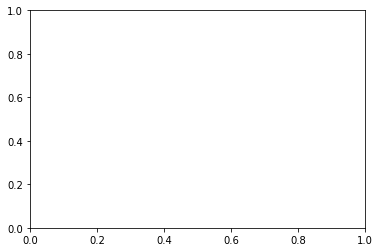

In [4]:
print('HPD Actual Data = {0} arcsecs.'.format(round(hpd(datacube.data)),5))

In [ ]:
print('HPD Actual Data = {0} arcsecs.'.format(round(hpd(Zout)),5))

In [ ]:
plate_scale